In [3]:
!pip install faker

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.0 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [65]:
from secrets import choice
from string import ascii_letters, digits
from scipy.stats import poisson
from typing import Union, List
from random import sample
import pandas as pd
from random import uniform, randint
from collections import namedtuple
import uuid

# Default size of token
DEFAULT_TOKEN_LENGTH = 10

# Mean number of items per itemsets
MEAN_ITEMS_PER_ITEMSET = 5


# Object Item
class Item:
    def __init__(self, identifier, value):
        self.identifier = identifier
        self.value = value

    @property
    def description(self):
        return f"description of {self.identifier}"

    def __repr__(self):
        return f"Item(identifier={self.identifier}, value={self.value})"


# Types
ItemsetSizeType = Union[int, float]
StringOrUUIDList = List[Union[str, uuid.UUID]]


def get_random_element(arr: list):
    return sample(arr, 1)[0]


def get_itemset_size(mean_items_per_itemset: int):
    return poisson.rvs(mean_items_per_itemset, size=1)[0]


def generate_random_tokens(
    num_tokens: int = 1, token_length: int = DEFAULT_TOKEN_LENGTH
):
    """Generate random tokens.

    Args:
        num_tokens (int, optional): Number of tokens to generate. Defaults to 1.
        token_length (int, optional): Length of each token. Defaults to DEFAULT_TOKEN_LENGTH.

    Returns:
        list: List of generated tokens.

    Examples:
    >>> len(generate_random_tokens())
    1
    >>> len(generate_random_tokens(5))
    5
    >>> all(len(token) == DEFAULT_TOKEN_LENGTH for token in generate_random_tokens())
    True
    >>> all(len(token) == 10 for token in generate_random_tokens(5, 10))
    True
    """

    tokens = []
    for _ in range(num_tokens):
        token = ''.join(choice(ascii_letters + digits) for _ in range(token_length))
        tokens.append(token)

    return tokens


def generate_item_ids(num_items: int):
    return generate_random_tokens(num_items, DEFAULT_TOKEN_LENGTH)


def generate_agent_ids(num_agents: int):
    return generate_random_tokens(num_agents, DEFAULT_TOKEN_LENGTH)


def generate_quantity(min_qty: float, max_qty: float):
    while True:
        yield randint(min_qty, max_qty)


def generate_value(min_value: float, max_value: float):
    while True:
        value = round(uniform(min_value, max_value), 2)
        yield value


def generate_item_dict(
    itemset_id: Union[int, str], agent_id: str, item: Item, quantity: int
):
    return {
        'itemset_id': itemset_id,
        'agent_id': agent_id,
        'item_id': item.identifier,
        'item_description': item.description,
        'item_quantity': quantity,
        'item_value': item.value,
    }


from typing import Tuple


def generate_quantified_item(items: List[Item], quantity_interval: Tuple[float]):
    item = get_random_element(items)

    min_qty = quantity_interval[0]
    max_qty = quantity_interval[1]
    quantity = next(generate_quantity(min_qty, max_qty))

    return item, quantity


def generate_items(num_items: int, value_interval: Tuple[float]):
    item_ids = generate_item_ids(num_items)

    # Generate available item ids
    def item_factory(item_props: Tuple):
        identifier = item_props[0]
        value = item_props[1]

        return Item(identifier, value)

    min_value, max_value = value_interval

    value_gen = generate_value(min_value, max_value)
    item_props_zip = zip(item_ids, value_gen)
    items = list(map(item_factory, item_props_zip))

    return items


def generate_itemset_list(
    itemset_id: int,
    agent_id: list,
    items: List[Item],
    quantity_interval: tuple,
    mean_items_per_itemset: ItemsetSizeType = MEAN_ITEMS_PER_ITEMSET,
):
    # Generate bin sizes using Poisson distribution
    itemset_size = get_itemset_size(mean_items_per_itemset)
    itemset = []
    for item in range(itemset_size):
        item, quantity = generate_quantified_item(items, quantity_interval)
        item_dict = generate_item_dict(itemset_id, agent_id, item, quantity)

        itemset.append(item_dict)

    return itemset


def generate_itemsets_dataframe(
    num_itemsets: int,
    num_items: int,
    num_agents: int,
    quantity_interval: Tuple[int],
    value_interval: Tuple[float],
    mean_items_per_itemset: int = MEAN_ITEMS_PER_ITEMSET,
):
    items = generate_items(num_items, value_interval)
    agent_ids = generate_agent_ids(num_agents)

    # Generate orders, items, and descriptions
    itemsets = []
    for itemset_id in range(num_itemsets):
        itemset_id_ = itemset_id + 1
        agent_id_ = get_random_element(agent_ids)

        itemset = generate_itemset_list(
            itemset_id_, agent_id_, items, quantity_interval, mean_items_per_itemset
        )
        itemsets = itemsets + itemset

    # Create a DataFrame from the generated data
    return pd.DataFrame(itemsets)

In [66]:
import pandas as pd
import numpy as np
from scipy.stats import poisson

# Set seed for reproducibility
np.random.seed(0)

# Parameters
num_itemsets = 10
num_items = 100
num_agents = 20

quantity_interval = (10, 20)
value_interval = (0, 100)

itemsets_df = generate_itemsets_dataframe(
    num_itemsets, num_items, num_agents, quantity_interval, value_interval
)

# Display the DataFrame
print(itemsets_df)

    itemset_id    agent_id     item_id           item_description  \
0            1  n8imzusGGx  sS9IPrLWDX  description of sS9IPrLWDX   
1            1  n8imzusGGx  WDTal01fHV  description of WDTal01fHV   
2            1  n8imzusGGx  tfW67EDm91  description of tfW67EDm91   
3            1  n8imzusGGx  7xEH4GB3Ah  description of 7xEH4GB3Ah   
4            1  n8imzusGGx  sS9IPrLWDX  description of sS9IPrLWDX   
5            1  n8imzusGGx  48dimsKalS  description of 48dimsKalS   
6            1  n8imzusGGx  nOicavATKy  description of nOicavATKy   
7            1  n8imzusGGx  FWEb3S7aR3  description of FWEb3S7aR3   
8            1  n8imzusGGx  DZGila1a1U  description of DZGila1a1U   
9            2  pMitUsmGi0  3JoJhgIvks  description of 3JoJhgIvks   
10           2  pMitUsmGi0  JW8vJ7nXEk  description of JW8vJ7nXEk   
11           2  pMitUsmGi0  FWEb3S7aR3  description of FWEb3S7aR3   
12           2  pMitUsmGi0  BwqXhF8r5X  description of BwqXhF8r5X   
13           2  pMitUsmGi0  wzJ0vi

In [64]:
import pandas as pd

# Sample DataFrame
data = {'order_id': [1, 1, 2, 2, 3], 'item_id': ['A', 'B', 'A', 'C', 'B']}
df = pd.DataFrame(data)

# Group by 'item_id' and aggregate 'order_id' into lists
item_order_dict = df.groupby('item_id')['order_id'].agg(list).to_dict()

print(item_order_dict)

{'A': [1, 2], 'B': [1, 3], 'C': [2]}


In [2]:
!pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.9 MB/s eta 0:00:009.4 MB/s eta 0:00:01m


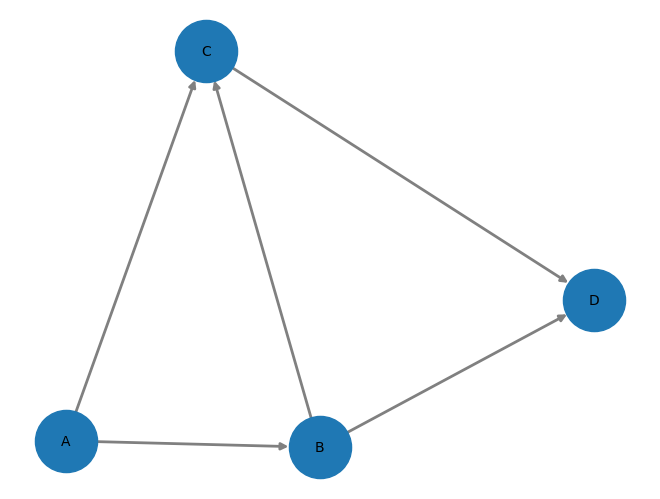

Degree Centrality: {'A': 0.6666666666666666, 'B': 1.0, 'C': 1.0, 'D': 0.6666666666666666}
Betweenness Centrality: {'A': 0.0, 'B': 0.08333333333333333, 'C': 0.08333333333333333, 'D': 0.0}
Closeness Centrality: {'A': 0.0, 'B': 0.3333333333333333, 'C': 0.6666666666666666, 'D': 0.75}


NetworkXNotImplemented: not implemented for directed type

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample data
edges = [
    ('A', 'B', {'support': 0.8}),
    ('A', 'C', {'support': 0.6}),
    ('B', 'C', {'support': 0.7}),
    ('B', 'D', {'support': 0.5}),
    ('C', 'D', {'support': 0.4})
]

# Create a directed graph
G = nx.DiGraph()

# Add edges with support values
G.add_edges_from(edges)

# Visualize the graph
nx.draw(G, with_labels=True, node_size=2000, font_size=10, edge_color='gray', width=2, edge_cmap=plt.cm.Blues)
plt.show()

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
print("Degree Centrality:", degree_centrality)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
print("Betweenness Centrality:", betweenness_centrality)

# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)
print("Closeness Centrality:", closeness_centrality)

# Identify communities
communities = nx.algorithms.community.label_propagation.label_propagation_communities(G)
print("Communities:", list(communities))

# Perform random walk
random_walk = nx.pagerank(G)
print("Random Walk:", random_walk)